## Splitting data into train val and test set

This jupyter notebook is used to splitting the data and saving the data into seperate folders to be able to don't risk that inadvertently change in the datasets later in the process.

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
from PIL import Image
import shutil
import random
from IPython.display import display


In [2]:
def Dataframe_data(root_path):
    
    # Annotationsdata
    data = pd.read_csv(root_path + 'AnnotationsCollated.csv', delimiter=';', header=None)

    #Delete questionable
    image_type = data.iloc[:,5]

    index_list = []
    for index, row in image_type.iteritems():
        if row == 'Questionable':
            index_list.append(index)
    data = data.drop(index=index_list)
    display(data)

    # Name Dataframe
    names = data.iloc[:,3]
    number = data.iloc[:,4]

    names_concat = pd.concat([names, number], axis=1)
    names_concat.columns = ['Name', 'Number']
    names_concat['Name'] = names_concat['Name'].astype(str) + '_' + names_concat['Number'].astype(str)
    new_name = names_concat.iloc[:,0].values

    # Label Dataframe
    number_of_boxes = data.iloc[:,6]
    box = data.iloc[:,7]
    label_t_l = data.iloc[:,8]
    label_v_a = data.iloc[:,5]
    label_concat = pd.concat([number_of_boxes, box, label_t_l, label_v_a], axis=1)

    return new_name, label_concat

root_path = '/Volumes/T7/ProcessedRequestData/ProcessedData/'
X, y = Dataframe_data(root_path)




,0,1,2,3,4,5,6,7,8
0,Patient1,Case1,MeasurementSet1,eda1fb4b-0902-4cd1-837c-bddd221fddb6,63,Unknown,0,[],[]
1,Patient1,Case1,MeasurementSet2,ce699728-7891-4af5-bb0c-ce4067f65a89,16,Aorta,1,"[[(2, 26), (232, 527)]]",['T']
2,Patient1,Case1,MeasurementSet3,8b8aa37a-3905-4753-bb0b-f7b7661bc40a,37,Aorta,1,"[[(5, 30), (229, 520)]]",['T']
3,Patient1,Case1,MeasurementSet4,f7f27ea3-b1e5-49e0-ad52-29bb2c4c58f2,37,Unknown,0,[],[]
4,Patient1,Case1,MeasurementSet5,3fc88f9a-11de-4de8-813c-de2095d41eb7,37,Unknown,0,[],[]
...,...,...,...,...,...,...,...,...,...
14741,Patient184,Case1,MeasurementSet1,73c6d87e-a203-4ed7-9342-8b0ff88e2825,31,Unknown,0,[],[]
14742,Patient184,Case1,MeasurementSet2,909bd4a8-f27b-4af2-ae3c-5288db32f1f3,58,Unknown,0,[],[]
14743,Patient184,Case1,MeasurementSet3,60f1babb-72a5-4d62-b966-783caeb6c07d,77,Unknown,0,[],[]
14744,Patient184,Case1,MeasurementSet4,959c8ab2-7426-492a-be16-b02d61f2b0ed,37,Unknown,0,[],[]


In [3]:
def split_data(X,y):

    # Splitting into training data and test/val data
    seed = 123
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,test_size=0.3, shuffle=True, random_state=seed)

    # Splitting the test data into validation and test data
    seed = 665
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=True, random_state=seed)

    print('Size of the training dataset: ', len(X_train))
    print('Size of the validation dataset: ', len(X_val))
    print('Size of the test dataset: ', len(X_test))

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X,y)

Size of the training dataset:  9621
Size of the validation dataset:  2062
Size of the test dataset:  2062


#### Saving the data into separate folders

9ea45640-665a-49e0-a426-7c8eee1ba212_77


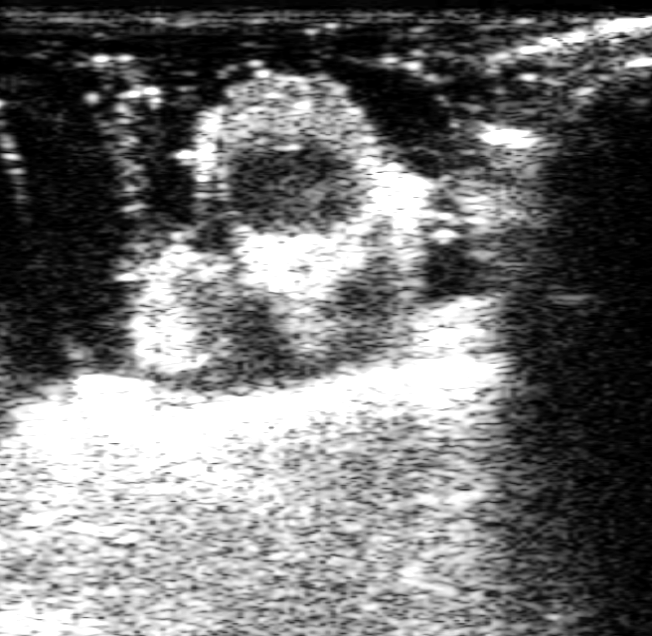

In [46]:
def actual_images(root_path):
    #Imagedata
    image_dict = {}

    # root = working directory, dirs = name of any sub_directories, files = present files in working directory
    for root, dirs, files in os.walk(root_path):
        pathfolder = os.path.basename(root)

        #Only go through folders that starts with MeasurementSet
        if pathfolder.startswith('MeasurementSet'):
            for image in files:

                #Add all the png files directories to a dict called image_dict
                if (image.endswith(".png")):
                    image_dict[os.path.splitext(image)[0]] = f'{root}/{image}'

    return image_dict

image_dict = actual_images(root_path)
print(random.choice(list(image_dict)))

# plot a random image
im = Image.open(random.choice(list(image_dict.values())))
display(im)



Training data into the folder TrainingData

In [60]:
def copy_images(X, image_dict, out_path):
    for element in X:
        for key, value in image_dict.items():
            # print(f'This is element {element}, this is key {key}')
            if element == key:
                shutil.copy(value, out_path)


In [61]:
def labels_txt(X, y, data_path, label_path):
    for image, label in zip(X, y.values):
        number = label[0]

        if number == 0:
            continue

        if label[3] == "Unknown" or label[3] == "Questionable" or label[3] == "Blank":
            continue

        # Replace the string with right characters and reshape. 
        box = label[1].replace("(", "").replace("[", "").replace(")", "").replace("]", "").replace(" ", "").split(",")
        box_array = np.array([int(character) for character in box]).reshape(number, 4)

        # Normalize the labels with width and height
        img = Image.open(f'{data_path}/{image}.png')
        height = img.height
        width = img.width

        new_array = []
        # Change the labels in right format of the bounding boxes; x_center, y_center, width, height
        for box_element in box_array:

            #If box_width is out of bound with image width
            box_element_width = box_element[2] 
            if box_element[2] > width:
                box_element_width = width
            
            if box_element[2] < 0:
                box_element_width = 0

            x_center = (((box_element_width - box_element[0])/2) + box_element[0])/width
            y_center = (((box_element[3] - box_element[1])/2) + box_element[1])/height
            box_width = (box_element_width - box_element[0])/width
            box_height = (box_element[3] - box_element[1])/height

            if box_element[0] > box_element_width:
                x_center = (((box_element[0] - box_element[2])/2) + box_element_width)/width
                box_width = (box_element[0] - box_element_width)/width

            if box_element[1] > box_element[3]:
                y_center = (((box_element[1] - box_element[3])/2) + box_element[3])/height
                box_height = (box_element[1] - box_element[3])/height

            new_array.append([x_center, y_center, box_width, box_height])


        # Character label
        char_label = label[2].replace("[", "").replace("]", "").replace("'", "").replace(" ", "").replace("T", "0").replace("L", "1").split(",")
        label_array = np.array([int(character) for character in char_label]).reshape(number, 1) 
        
        # Vessel, Anastomosis or Aorta
        type_label = label[3].replace("", "").replace(" ", "").replace("Vessel","2").replace("Anastomosis","3").replace("Aorta","4").split(",")  
        type_array = np.array([np.repeat(int(typ), number) for typ in type_label]).reshape(number, 1)

        # write the labelling file
        filename = (f'{image}'+'.txt')
        new_file_path = os.path.join(f'{label_path}/{filename}')
        new_file = open(new_file_path, 'w')

        for label_1, label_2, object in zip(label_array, type_array, new_array):
            new_file.write(f'{label_1[0]}' + ' ')

            for num in object:
                new_file.write(f'{num}' + ' ')
            new_file.write('\n')
            
            new_file.write(f'{label_2[0]}' + ' ')

            for num in object:
                new_file.write(f'{num}' + ' ')
            new_file.write('\n')
        new_file.close()
     
    

Training data into Training folder

In [ ]:
TrainingData_path = '/Volumes/T7/Master/datasets/Request/images/train'
traininglabel_path = '/Volumes/T7/Master/datasets/Request/labels/train'
copy_images(list(X_train), image_dict, TrainingData_path)
labels_txt(X_train, y_train, TrainingData_path,traininglabel_path)

Validation data into ValidationData

In [1]:
ValidationData_path = '/Volumes/T7/Master/datasets/Request/images/val'
validationlabel_path = '/Volumes/T7/Master/datasets/Request/labels/val'
copy_images(list(X_val), image_dict, ValidationData_path)
labels_txt(X_val, y_val, ValidationData_path, validationlabel_path)

NameError: name 'copy_images' is not defined

Test data into TestData

In [63]:
TestData_path = '/Volumes/T7/Master/datasets/Request/images/test'
testlabel_path = '/Volumes/T7/Master/datasets/Request/labels/test'
copy_images(list(X_test), image_dict, TestData_path)
labels_txt(X_test, y_test, TestData_path, testlabel_path)
